In [7]:
import keyring
import pandas as pd
from sqlalchemy import create_engine

password = keyring.get_password("mysql-rocketpig", "root")
user = 'root'
host = '220.76.60.248'
port = '3306'  # 기본적으로 MySQL은 3306 포트를 사용합니다
db = 'stock_db'

# SQLAlchemy 엔진 생성
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{db}?charset=utf8")

# 연결 테스트
with engine.connect() as connection:
    print("SQLAlchemy로 MySQL 연결 성공!")

SQLAlchemy로 MySQL 연결 성공!


In [8]:
acc_no_0 = "63981494-01" # 위탁
acc_no_1 = "64267316-22" # 연금저축 1
acc_no_2 = "64012548-22" # 연금저축 2
acc_no_isa = "64043278-01" # ISA
acc_no_irp = "64012548-29" # IRP

In [9]:
query = "SELECT * FROM deposit"
입금 = pd.read_sql(query, con=engine)
입금.set_index('거래일', inplace=True)
query = "SELECT * FROM withdraw"
출금 = pd.read_sql(query, con=engine)
출금.set_index('거래일', inplace=True)
query = "SELECT * FROM distribution"
분배금 = pd.read_sql(query, con=engine)
분배금.set_index('거래일', inplace=True)
query = "SELECT * FROM interest"
이자 = pd.read_sql(query, con=engine)
이자.set_index('거래일', inplace=True)
query = "SELECT * FROM stock"
주식 = pd.read_sql(query, con=engine)
주식.set_index('거래일', inplace=True)

In [10]:
일별입금 = 입금.groupby('거래일').agg({'정산금': 'sum'})
일별출금 = 출금.groupby('거래일').agg({'정산금': 'sum'})
일별분배금 = 분배금.groupby('거래일').agg({'정산금': 'sum'})
일별이자 = 이자.groupby('거래일').agg({'정산금': 'sum'})
일별주식 = 주식.groupby('거래일').agg({'정산금': 'sum'})

일별입금 = 일별입금.resample('D').sum().fillna(0)
일별출금 = 일별출금.resample('D').sum().fillna(0)
일별분배금 = 일별분배금.resample('D').sum().fillna(0)
일별이자 = 일별이자.resample('D').sum().fillna(0)
일별주식 = 일별주식.resample('D').sum().fillna(0)

일별입금.columns = ['입금']
일별출금.columns = ['출금']
일별분배금.columns = ['분배금']
일별이자.columns = ['이자']
일별주식.columns = ['주식']

입출금 = pd.concat([일별입금, 일별출금, 일별분배금, 일별이자, 일별주식], axis=1).fillna(0)
입출금['입출금'] = 입출금['입금'] - 입출금['출금']
입출금['입출금'] = 입출금['입출금'].cumsum()
입출금['총현금'] = 입출금['입금'] - 입출금['출금'] + 입출금['분배금'] + 입출금['이자'] + 입출금['주식']
입출금['총현금'] = 입출금['총현금'].cumsum()

# 일별입출금 = 입금['정산금'] - 출금['정산금']
# 입출금 = pd.merge(일별입금, 일별출금, on='거래일', how='outer').fillna(0)
# 입출금['test'] = 입출금['잔고_x'] - 입출금['잔고_y']
# 일별입금.set_columns(['입금'])
# # display(일별입금)
# 일별입금['잔고'] = 일별입금['입금'].cumsum()

In [11]:
from datetime import datetime
import yfinance as yf

def get_stock_price(code, start_date):
    ticker = f'{code}.KS'
    today = datetime.today().strftime('%Y-%m-%d')
    stock_data = yf.download(ticker, start=start_date, end=today, progress=False)
    close_prices = stock_data[['Close']]
    close_prices = close_prices.resample('D').ffill()
    # display(close_prices)
    return close_prices


df = pd.DataFrame()

def extend_today(df, start):
    # 오늘 날짜 가져오기
    today = datetime.today().strftime('%Y-%m-%d')
    # 일간으로 리샘플링하고, forward fill로 채우기
    date_range = pd.date_range(start=start, end=today, freq='D')
    df_resampled = pd.DataFrame(index=date_range)
    df_resampled = df_resampled.join(df)
    df_resampled.index.name = '거래일'
    return df_resampled

for code in 주식['코드'].unique():
    주식코드 = 주식[주식['코드'] == code].copy()
  
    주식코드 = 주식코드.pivot_table(index=['거래일'], columns='계좌', values=['보유'], aggfunc='first').ffill().fillna(0)
    주식코드합 = 주식코드.T.groupby(level=0).sum().T
    주식코드합.columns = [code]
    주식코드합 = extend_today(주식코드합, 주식.index.min()).ffill().fillna(0)
    주식가격 = get_stock_price(code, 주식.index.min())
    주식가격 = extend_today(주식가격, 주식.index.min()).ffill()
    주식코드합[code] *= 주식가격['Close']
    # display(주식코드)
    # display(주식코드합)
    
    # for account in 주식['계좌'].unique():
    #     주식코드 = 주식[(주식['코드'] == code) & (주식['계좌'] == account)].copy()
    #     주식코드 = 주식코드.groupby('거래일').agg({'보유': 'sum'})
    #     주식코드 = extend_today(주식코드, 주식.index.min()) 
    #     주식
    #     # 주식가격 = get_stock_price(code, 주식코드.index.min(), 주식코드.index.max())
    #     # 주식가격 = extend_today(주식가격) 
    #     # 주식코드['종가'] = 주식가격['Close']
    #     # 주식코드['평가'] = 주식코드['보유'] * 주식가격['Close']
    #     # 주식코드.reset_index(inplace=True)
    #     # 주식코드.columns = ['거래일', code, f'{code}_종가', f'{code}_평가']
    #     # 주식코드.set_index('거래일', inplace=True)
    #     display(주식코드)
    #     # display(주식가격)
        
    df = pd.concat([df, 주식코드합], axis=1).fillna(0)
    
    
    
입출금['평가금액'] = df.sum(axis=1)
입출금['총자산'] = 입출금['총현금'] + 입출금['평가금액']


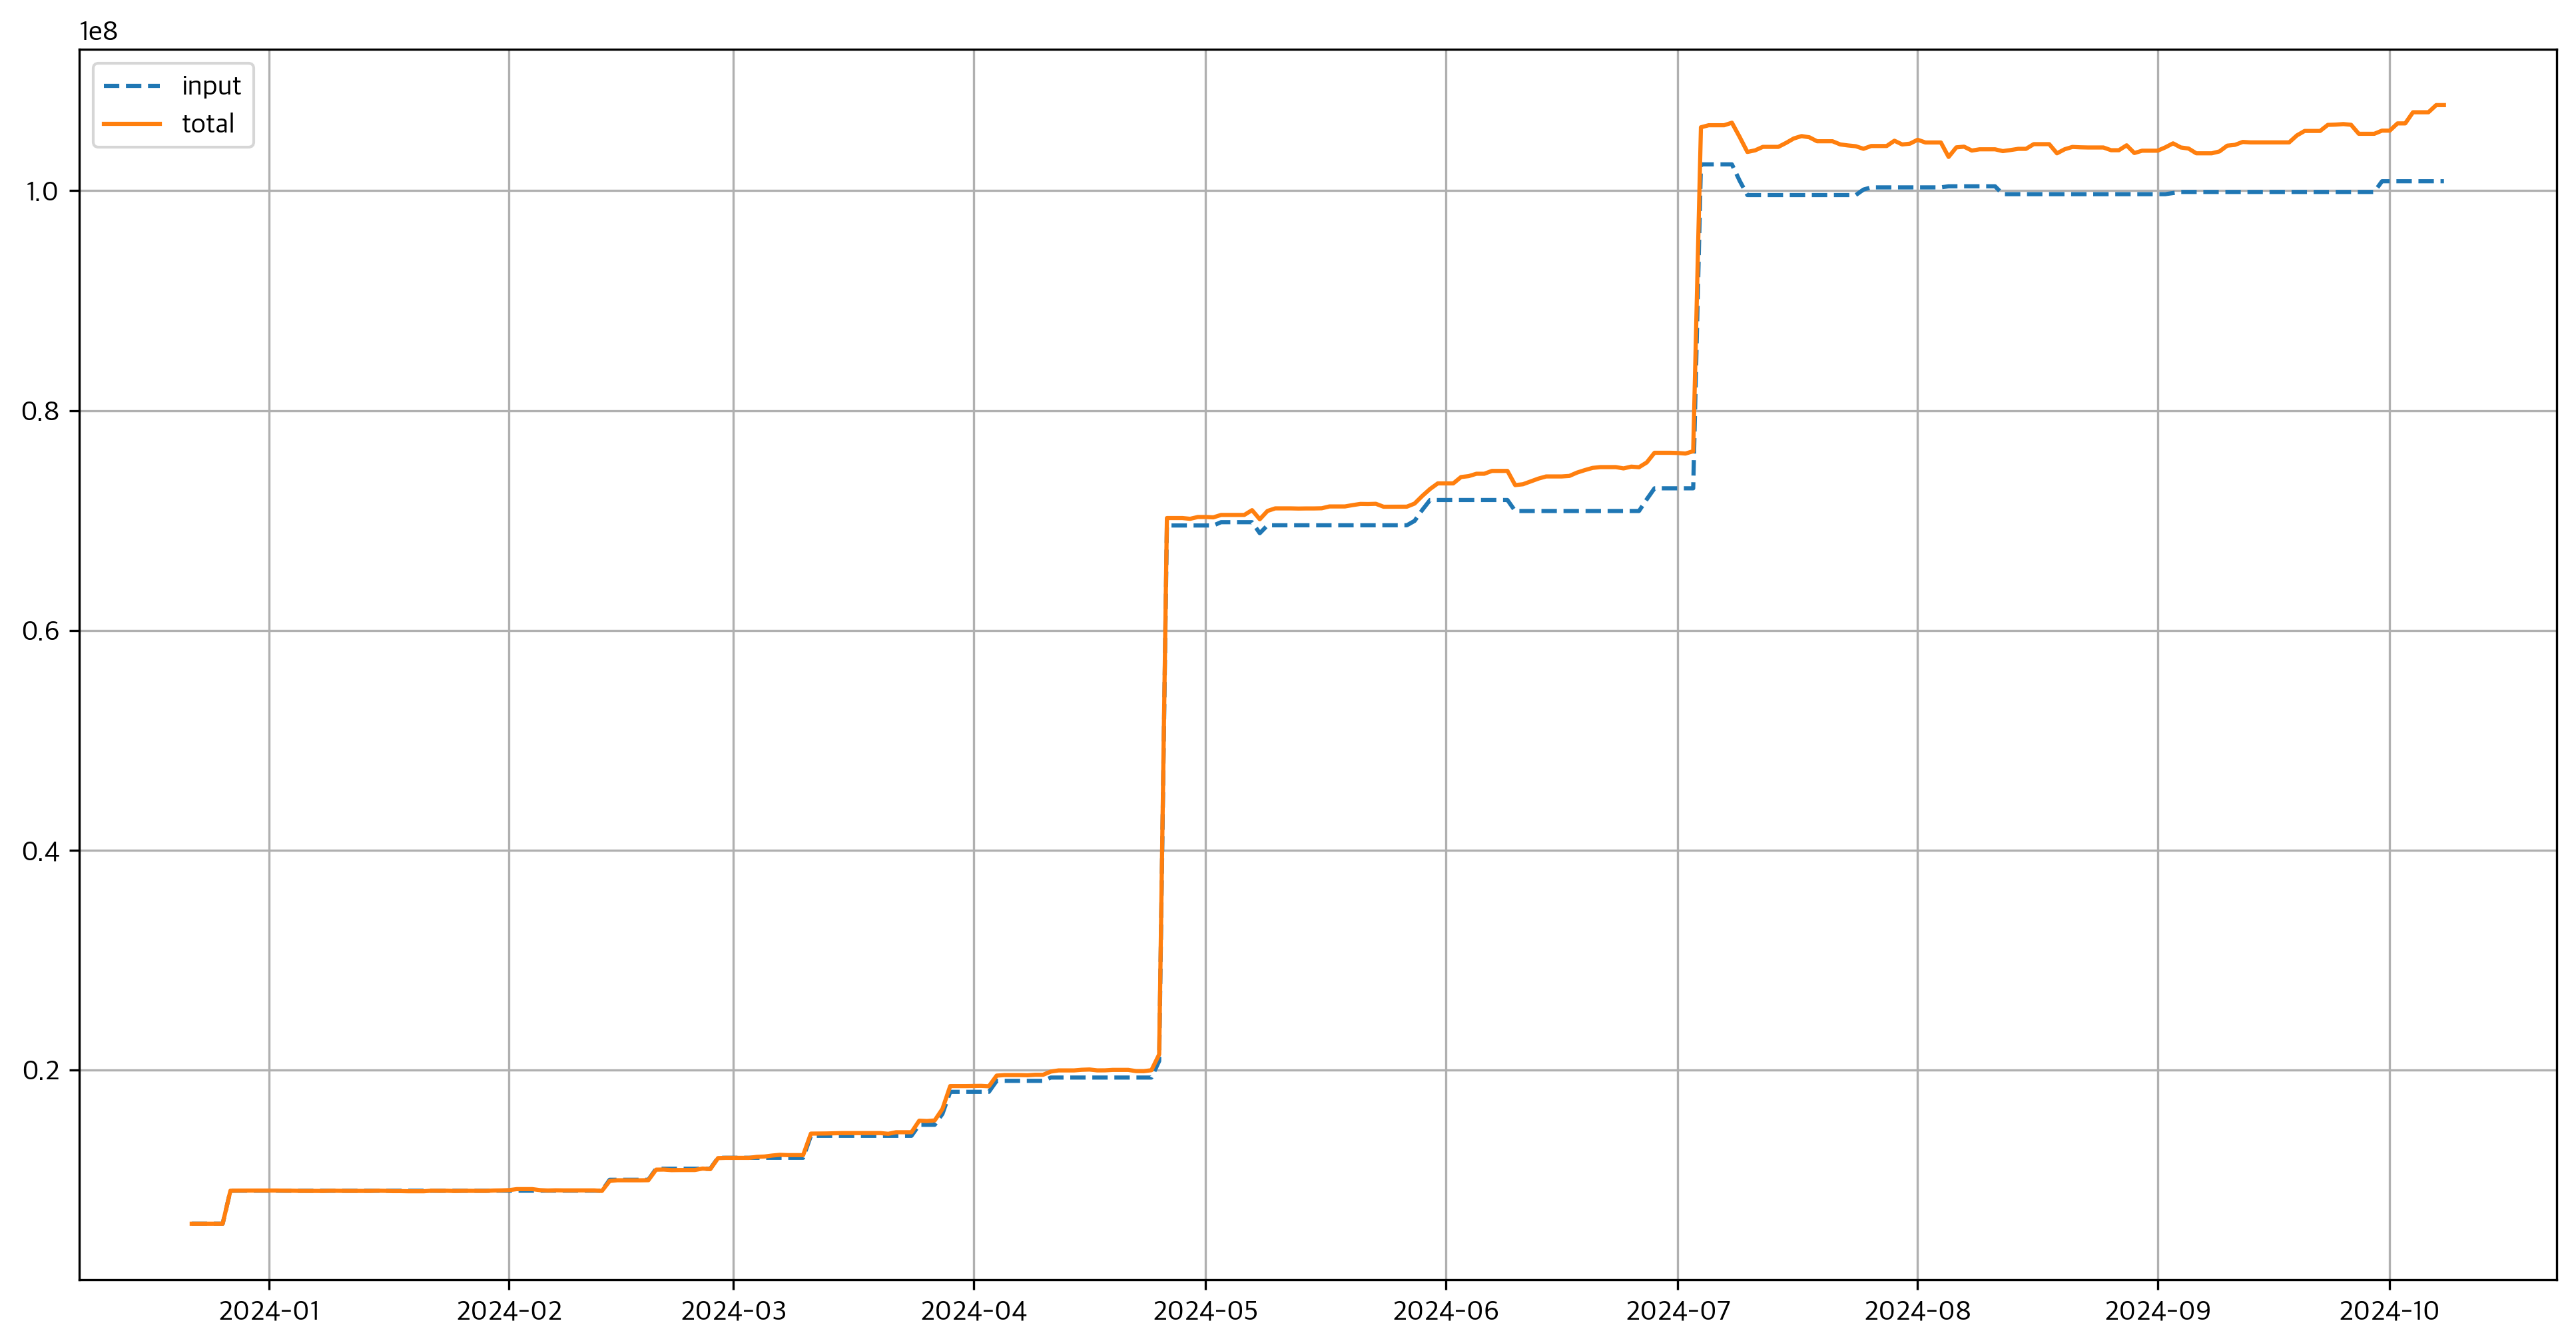

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(입출금['입출금'], label='input', linestyle='--')
# plt.plot(입출금['총현금'], label='output')
# plt.plot(입출금['평가금액'], label='stock')
plt.plot(입출금['총자산'], label='total')
plt.grid(True)
plt.legend()

In [13]:

입출금 = extend_today(입출금)
입출금['총현금'] = 입출금['총현금'].ffill()
총현금 = 입출금[['총현금']]

TypeError: extend_today() missing 1 required positional argument: 'start'

,148070,195980,272580,284430,360750,411060,472870,423160,449170,360200,...,468380,464540,480020,482730,483230,114800,453810,489250,475380,218420
2023-12-22,-114685.0,-53820.0,-106190.0,-286580.0,-169785.0,-146940.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-05,0.0,0.0,0.0,0.0,0.0,-2005334.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-09-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-09-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-09-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,합계
2023-12-22,-878000.0
2023-12-23,0.0
2023-12-24,0.0
2023-12-25,0.0
2023-12-26,0.0
...,...
2024-09-05,-73364.0
2024-09-06,0.0
2024-09-07,0.0
2024-09-08,0.0


In [140]:
def clean_code(df):
    df = df.pivot_table(index=['거래일'], columns='코드', values=['종류', '거래금', '수량', '정산금', '수수료', '세금', '상품명', '계좌'], aggfunc='first')
    df['상품명'] = df['상품명'].apply(lambda col: col.ffill().bfill())
    df['계좌'] = df['계좌'].apply(lambda col: col.ffill().bfill())
    df['종류'] = df['종류'].apply(lambda col: col.ffill().bfill())
    df.fillna(0, inplace=True)

    new_order = ['종류', '거래금', '수량', '정산금', '수수료', '세금', '상품명', '계좌']
    df = df.reorder_levels([1, 0], axis=1).sort_index(axis=1)
    df = df.reindex(columns=pd.MultiIndex.from_product([df.columns.levels[0], new_order]))
    
    return df 

# for code in 주식['코드'].unique():
#     df = 주식[주식['종류'] == '거래소매수' & 주식['코드'] == code]
#     df = clean_code(df)
#     # 매도 = 주식[주식['종류'] == '거래소매도']
#     display(df)
